In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bluepysnap as bp
from matplotlib.collections import LineCollection
from morphio import Morphology
import json
import matplotlib
import h5py
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams.update({'font.size': 12})
%matplotlib notebook

In [2]:
s1 = bp.Simulation('distant-electrodes/simulation/simulation_config.json')
r1 = s1.reports['extracellular_report']['S1nonbarrel_neurons']

start_time = 2125 
end_time = 2500
data1 = r1.get(t_start=start_time,t_stop=end_time)

# s2 = bp.Simulation('simulation_smallSphere/simulation_config.json')
# r2 = s2.reports['extracellular_report']['S1nonbarrel_neurons']

# data2 = r2.get(t_start=start_time,t_stop=end_time)

<IPython.core.display.Javascript object>


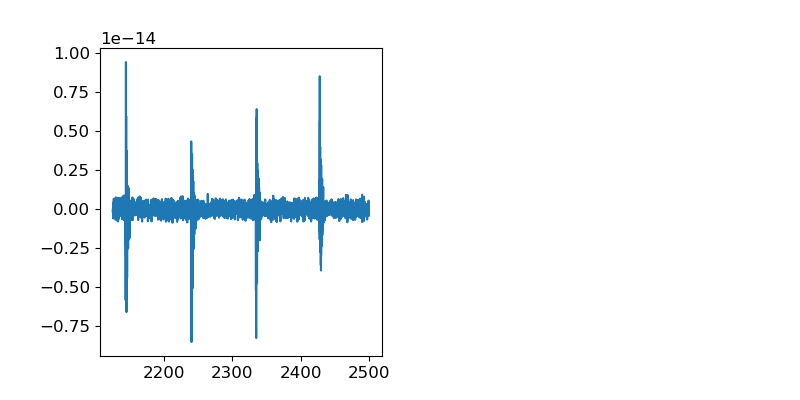

In [5]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)

plt.plot(data1.iloc[:,0])
# plt.plot(data1.iloc[:,1])
# plt.plot(data1.iloc[:,2]-data1.iloc[:,3])
# plt.plot(data1.iloc[:,4]-data1.iloc[:,5])


# plt.xlabel('Time (ms)')
# plt.ylabel('Signal (V)')

# plt.subplot(1,2,2)

# plt.plot(data2.iloc[:,0])
# plt.plot(data2.iloc[:,1])
# plt.plot(data2.iloc[:,2]-data2.iloc[:,3])
# plt.plot(data2.iloc[:,4]-data2.iloc[:,5])

# plt.xlabel('Time (ms)')

# plt.legend(['Reciprocity','Dipole','PointSource','LineSource'])

# plt.savefig('figures/verification.png',dpi=300)

In [3]:
f = h5py.File('distant-electrodes/electrodeFile/coeffs.h5')

In [4]:
scalingFactors = f['electrodes']['S1nonbarrel_neurons']['scaling_factors']

In [6]:
cell_positions = pd.read_pickle('../../data/getPositions/positions/0/positions0.pkl')



FileNotFoundError: [Errno 2] No such file or directory: '../../data/getPositions/positions/0/positions0.pkl'

In [7]:
def getNeuronSegmentMidpts(position):
    '''
    Gets midpoints for a single neuron
    '''

    
    secIds = np.array(list(position.columns))[:,1]
    uniqueSecIds = np.unique(secIds)

    for sId in uniqueSecIds: # Iterates through sections

        pos = position.iloc[:,np.where(sId == secIds)[0]]

        if sId == 0: # Implies that section is a soma, so we just take the position from the file

            newPos = pos
 
        elif np.shape(pos.values)[-1] == 1: # If there is only one point in the section, we just take the value
            newPos = pd.concat((newPos,pos),axis=1)

        else: # We take the midpoints of the values in the file, which are the endpoints of the segments
            pos = (pos.iloc[:,:-1]+pos.iloc[:,1:])/2

            newPos = pd.concat((newPos,pos),axis=1)

    return newPos


In [8]:
midpts = getNeuronSegmentMidpts(cell_positions)

NameError: name 'cell_positions' is not defined

In [9]:
plt.figure(figsize=(8,4))

plt.subplot(111,projection='3d')

ax = plt.gca()

plot = ax.scatter(midpts.values[0,:],midpts.values[1,:],midpts.values[2,:],c=scalingFactors[:,2])

plt.axis('off')

cbar = plt.colorbar(plot,label='Scaling Factor (V/nA)')

plt.tight_layout()

# plt.subplot(132,projection='3d')

# ax = plt.gca()

# plot = ax.scatter(midpts.values[0,:],midpts.values[1,:],midpts.values[2,:],c=(scalingFactors[:,5]))

# plt.axis('off')

# cbar = plt.colorbar(plot,label='Scaling Factor (V/nA)')

# plt.tight_layout()

# plt.subplot(133)

# plt.plot(data.index-2705,data.iloc[:,2]*1e3)
    
# # plt.plot(data.index-2705,data.iloc[:,6]*1e3-data.iloc[:,9]*1e3)
# # plt.plot(data.index-2705,data.iloc[:,4]*1e3-data.iloc[:,5]*1e3)
# plt.plot(data.index-2705,(data.iloc[:,5]*1e3))
# # plt.plot(data.index-2705,data.iloc[:,2]*1e3*1e9)
# # plt.plot(data.index-2705,data.iloc[:,4]*1e3*1e9)
# # plt.plot(data.index-2705,data.iloc[:,4]*1e3-data.iloc[:,5]*1e3)
    
# plt.ylabel('EEG (mV)')
# plt.xlabel('Time (ms)')

# plt.legend(['Reciprocity','Dipole reciprocity','LineSource','PointSource'])

# plt.tight_layout()

# plt.savefig('Figure.png',dpi=300)

<IPython.core.display.Javascript object>

NameError: name 'midpts' is not defined

In [14]:
r1 = s.reports['current']['S1nonbarrel_neurons']
r2 = s.reports['clamp']['S1nonbarrel_neurons']
data1 = r1.get(t_start=start_time,t_stop=end_time)
data2 = r2.get(t_start=start_time,t_stop=end_time)

In [17]:
d1 = data1.sum(axis=1)
d2 = data2.sum(axis=1)

<IPython.core.display.Javascript object>


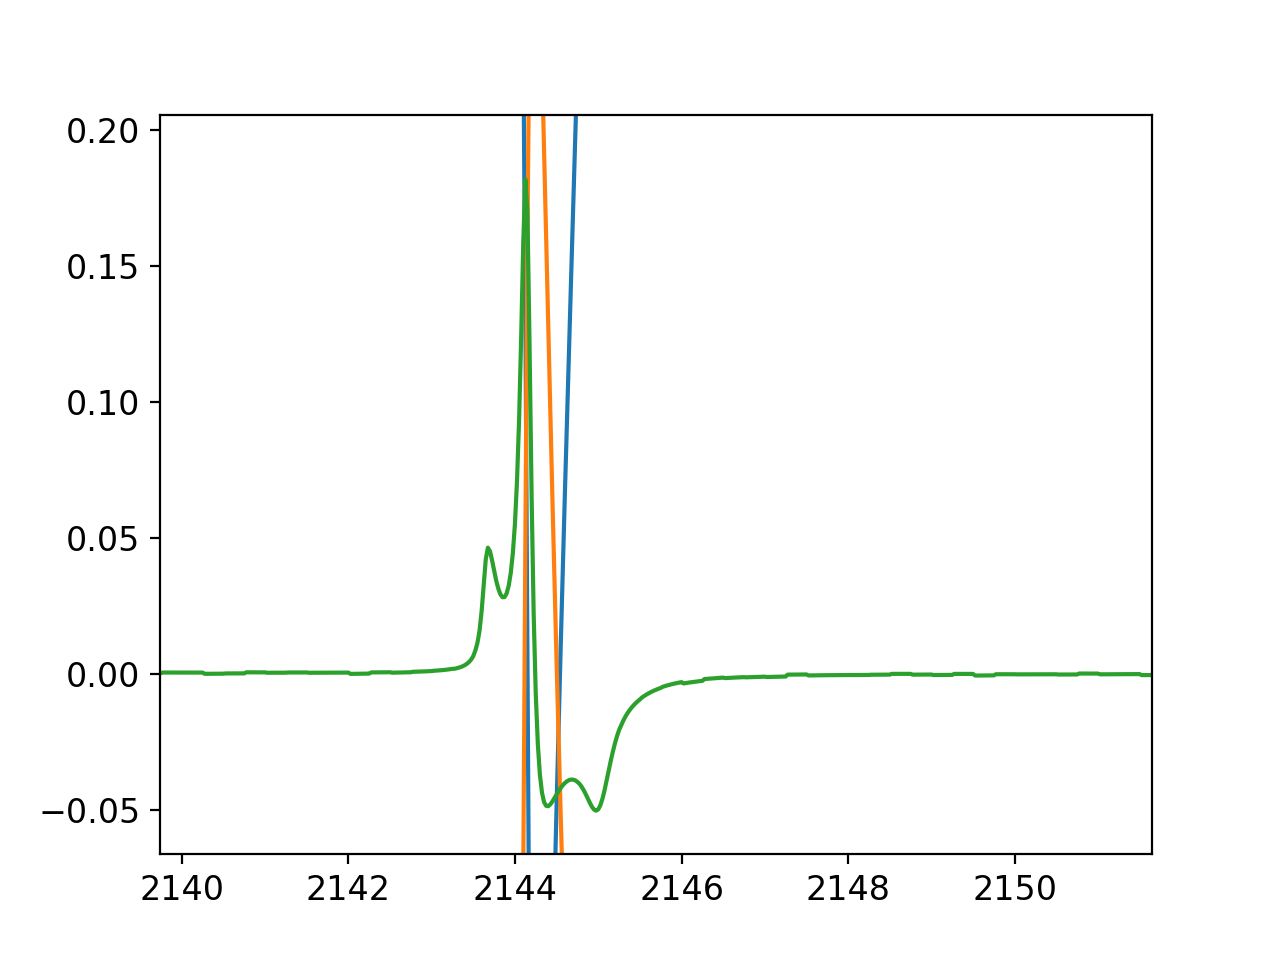

In [21]:
plt.figure()
plt.plot(d1)
plt.plot(d2)
plt.plot(d1+d2)